In [1]:
#imports

import numpy as np
import shelve
from astropy.table import QTable
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline


#initial conditions
stable_ICs = shelve.open('stable_ICs')
ecc_b = stable_ICs['ecc_b']
ecc_c = stable_ICs['ecc_c']
semi_b = stable_ICs['semi_b']
semi_c = stable_ICs['semi_c']
dInc_b = stable_ICs['dInc_b']
dInc_c = stable_ICs['dInc_c']
dLongA_b = stable_ICs['dLongA_b']
dLongA_c = stable_ICs['dLongA_c']
dArgP_b = stable_ICs['dArgP_b']
dArgP_c = stable_ICs['dArgP_c']
mean_an_b = stable_ICs['mean_an_b']
mean_an_c = stable_ICs['mean_an_c']
good_hill = stable_ICs['good_hill']
bad_hill = stable_ICs['bad_hill']
dPrecA_b = stable_ICs['dPrecA_b']
dMass_star = stable_ICs['dMass_star']
dRadius_star = stable_ICs['dRadius_star']
dMass_b = stable_ICs['dMass_b']
dMass_c = stable_ICs['dMass_c']
dRadius_b = stable_ICs['dRadius_b']
dRadius_c = stable_ICs['dRadius_c']
dTidalQ_b = stable_ICs['dTidalQ_b']
dTidalQ_c = stable_ICs['dTidalQ_c']
dTidalQ_star = stable_ICs['dTidalQ_star']
dStopTime = stable_ICs['dStopTime']
stable_ICs.close()

In [2]:
t = 25000 # number of sims




data_merged_runs = np.array([])
data_age = np.array([])
data_semi = np.array([])
data_ecc = np.array([])
data_m_star = dMass_star
data_m_b = dMass_b
data_per = np.array([])


folders = np.array([]) # corresponding folders



n = 0
while n <= t-1:     # builds the final vars from output files
    name_idx = '%05i'%n
    folder_name = name_idx
    wd = './runs/'+folder_name
    fwd = open(wd+'/system.b.forward','r')
    fwd_content = fwd.read()
    fwd_content = fwd_content.split('\n')
    last_line = fwd_content[-2]
    last_line = last_line.split(' ')
    max_age = last_line[0]
    max_age = float(max_age)
    str_max_age = str(max_age)
    str_max_age = str_max_age[0]
    sdigit_max_age = int(str_max_age)
    
    if max_age<=3e09: #throws away so able to generate age b/w 2 and 8 (excludes 2 and 2)
        data_merged_runs = np.append(data_merged_runs,int(folder_name))
    else:
        if max_age < 8e09: #generates age to max age
            age_rand = np.random.randint(2,sdigit_max_age)
            data_age = np.append(data_age,age_rand)
        
        elif max_age >= 8e09: #generates age 2 to 8 gyrs
            age_rand = np.random.randint(2,9)
            data_age = np.append(data_age,age_rand)

            
            
        line = fwd_content[age_rand]
        age = int(line[0])
        data = line.split(" ")
        ecc = float(data[2])
        semi = float(data[1])
        data_ecc = np.append(data_ecc,ecc)
        data_semi = np.append(data_semi,semi)
        #Tracer()()

    
    n += 1
data_m_star = np.delete(data_m_star,data_merged_runs)
data_m_b = np.delete(data_m_b,data_merged_runs)
data_m_b = abs(data_m_b)

data_m_star = data_m_star * u.earthMass
data_m_b = data_m_b * u.earthMass


a = data_semi * u.AU
per = np.sqrt(((4 * np.pi**2)/(const.G*(data_m_b + data_m_star)))*a**3)
per = per.decompose()
per = per.to(u.day)
per = per.value
data_per = per
# now to combine it all





In [3]:
data_semi = np.transpose(data_semi)
data_ecc = np.transpose(data_ecc)
data_age = np.transpose(data_age)
data_per = np.transpose(data_per)
data = np.vstack((data_age,data_semi,data_ecc,data_per))
data = np.transpose(data)
data.shape

(23248, 4)

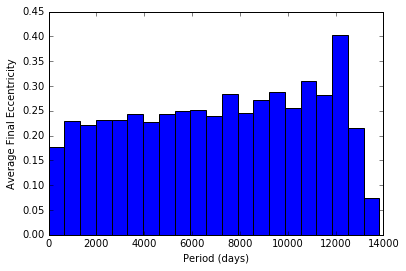

In [26]:
n = 20 #number of bins
binwidth = (max(data_per)-min(data_per))/n

#generate x axis'
x = np.arange(0,max(data_per),binwidth)
avg_ecc = np.array([])
#generate y axis, avg ecc per bin;

for l in x:
    
    lb = l
    ub = lb+binwidth
    ecc_bin = np.array([])
    
    for idx,per in enumerate(data_per):
        if per >= lb and per <= ub:
            ecc_bin = np.append(ecc_bin,data_ecc[idx])
            
    avg_ecc_bin = np.mean(ecc_bin)
    avg_ecc = np.append(avg_ecc,avg_ecc_bin)

    
x.shape,avg_ecc.shape,avg_ecc

fig,ax = plt.subplots(1,1)
ax.bar(x,avg_ecc,width=binwidth)
ax.set_xlabel('Period (days)')
ax.set_ylabel('Average Final Eccentricity')
        
    

In [5]:
# to find the run with the highest period:
print (np.argmax(data_per),data_per[np.argmax(data_per)])

17552 13205.0643758


In [6]:
#reads in data for completed/uncompleted hyak runs

ss = shelve.open('ss')

uncomp = ss['uncomp']
comp = ss['comp']
comp_runtime = ss['comp_runtime']

co_b_semi_list = ss['co_b_semi']
un_b_semi_list = ss['un_b_semi']

co_b_ecc_list = ss['co_b_ecc']
un_b_ecc_list = ss['un_b_ecc'] 

co_b_inc_list = ss['co_b_inc'] 
un_b_inc_list = ss['un_b_inc']

co_c_inc_list = ss['co_c_inc']
un_c_inc_list = ss['un_c_inc']

co_b_longa_list = ss['co_b_longa']
un_b_longa_list = ss['un_b_longa']

co_c_longa_list = ss['co_c_longa'] 
un_c_longa_list = ss['un_c_longa']

co_mut_incl = ss['co_mut_inc']
un_mut_incl = ss['un_mut_inc']

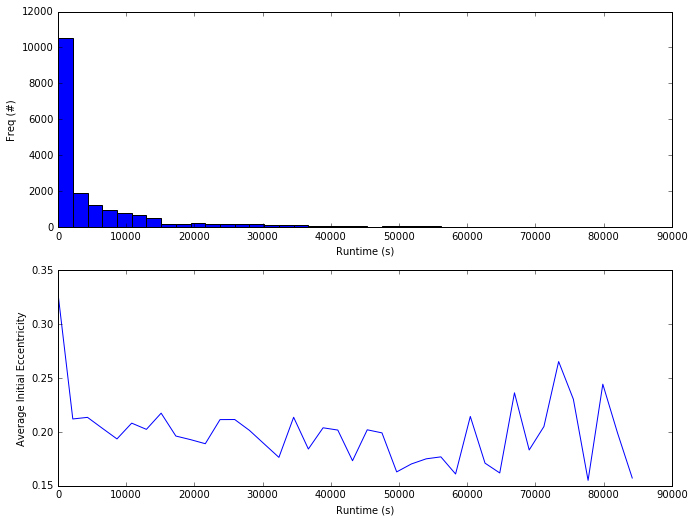

In [40]:
comp_runtime = comp_runtime.astype(np.float) #converts from strings to float

n = 40 #number of bins
binwidth = (max(comp_runtime)-min(comp_runtime))/n

x = np.arange(min(comp_runtime),max(comp_runtime),binwidth)
freq = np.array([])
avg_ecc = np.array([])

for l in x:
    lb = l
    ub = lb + binwidth
    freq_bin = 0
    ecc_bin = np.array([])
    for idx,time in enumerate(comp_runtime):
        if time >= lb and time <= ub:
            freq_bin += 1
            ecc_bin = np.append(ecc_bin,co_b_ecc_list[idx])
            
    freq = np.append(freq,freq_bin)
    avg_ecc_bin = np.mean(ecc_bin)
    avg_ecc = np.append(avg_ecc,avg_ecc_bin)
    



fig,ax = plt.subplots(2,1)
fig.set_size_inches(11,8.5)

ax[0].bar(x,freq,width=binwidth)
ax[0].set_xlabel('Runtime (s)')
ax[0].set_ylabel('Freq (#)')

ax[1].plot(x,avg_ecc)
ax[1].set_xlabel('Runtime (s)')
ax[1].set_ylabel('Average Initial Eccentricity')


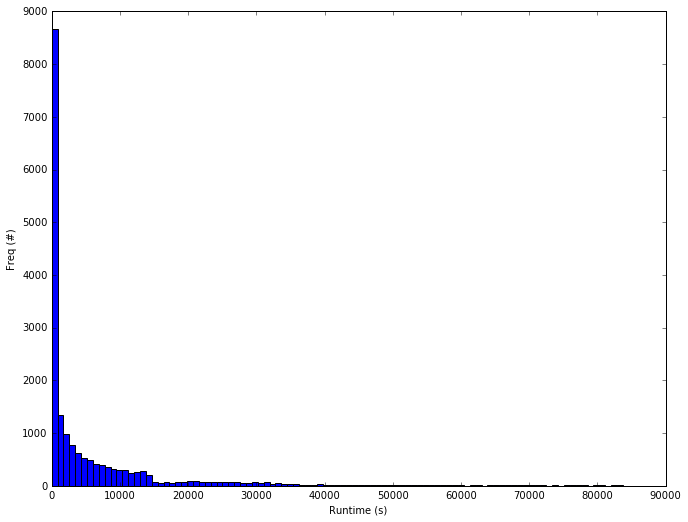

In [37]:
x[np.argmax(avg_ecc)

In [ ]:
# send rory case with large period, inputs
# see if longer runs have e > 0.22
# histogram of run times with freq (bins of runtime)
# ecc vs runtime
# np.argmax(data_per)